<div dir="rtl">
<h1>💡 ملاحظة هامة لتشغيل الدفتر</h1>
إذا لم يكن لديك (GPU) أو واجهت صعوبات في تشغيل هذا الدفتر محليًا، يمكنك تجربة النسخة المتوفرة عبر الإنترنت على منصة Kaggle <a href="https://www.kaggle.com/code/ninamaamary/arabic-handwritten-digits-recognizer">هنا</a>.
العمل على Kaggle يوفر لك غالبًا إمكانية الوصول إلى موارد حوسبة مجانية (مثل GPUs أو TPUs) تساعد في تسريع تنفيذ الأكواد التي تتطلب قوة معالجة عالية.
</div>


# Deep learning Approach

## Imports

In [1]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
import matplotlib.pyplot as plt
torch.manual_seed(200)

## Utilities

In [2]:
def extract_data(torch_subset):
    df = torch_subset.dataset.iloc[torch_subset.indices]
    x = torch.from_numpy(df.values[ : , 1:]).reshape(-1, 28, 28).to(torch.float)
    y = torch.from_numpy(df.values[:, 0]).to(torch.long)
    
    return x, y
    
    
def split(dataframe):
    val_size = len(dataframe)//6
    train_size = len(dataframe) - val_size
    
    train, valid = torch.utils.data.random_split(dataframe, [train_size, val_size])

    return extract_data(train), extract_data(valid)

def show_img(X, y):
    fig = plt.figure(figsize=(20, 5))
    for i in range(10):
        ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        ax.imshow(X[i].view(28, 28))
        ax.set_title(str(y[i].item()))

# Custom Dataset

In [3]:
class MNISTDS(torch.utils.data.Dataset):
    def __init__(self, images, targets, transforms=None):
        self.images = images.unsqueeze(1) / 255
        self.targets = targets
        self.transforms = transforms
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, i):
        if self.transforms:
            x = self.transforms(self.images[i])
        else:
            x = self.images[i]
        return x, self.targets[i]

## Load data and transform to torch tesnors

In [4]:
import zipfile

zip_file_path = './datasets/ahdd1/csvTrainImages 60k x 784.zip'
extraction_dir = './datasets/ahdd1/' 

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

In [5]:
train_df = pd.read_csv('./datasets/ahdd1/csvTrainImages 60k x 784.csv')
test_df = pd.read_csv('./datasets/ahdd1/csvTestImages 10k x 784.csv')

train_label = pd.read_csv('./datasets/ahdd1/csvTrainLabel 60k x 1.csv')
test_label = pd.read_csv('./datasets/ahdd1/csvTestLabel 10k x 1.csv') 

In [6]:
train_df.shape, train_label.shape, test_df.shape, test_label.shape

((59999, 784), (59999, 1), (9999, 784), (9999, 1))

In [6]:
train = pd.concat([train_label, train_df], axis=1)

train.head(3)

,0,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.486,0.487,0.488,0.489,0.490,0.491,0.492,0.493,0.494,0.495
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
(X_train, y_train), (X_val, y_val) = split(train)
X_test = torch.Tensor(test_df.values).reshape(-1, 28, 28)

### Explore

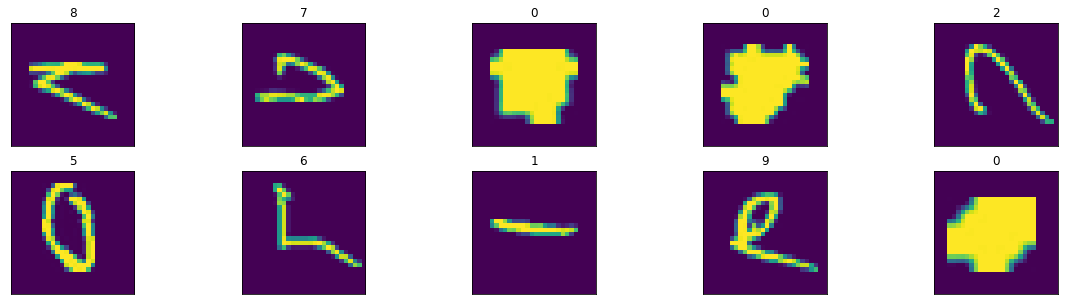

In [8]:
show_img(X_train, y_train)

## Data Augmentation

In [9]:
import torchvision.transforms as transforms

transform = torch.nn.Sequential(
    transforms.RandomAffine(degrees=90, scale=(1.1, 1.1), fillcolor=None),
)
scripted_transforms = torch.jit.script(transform)

### View augmented data

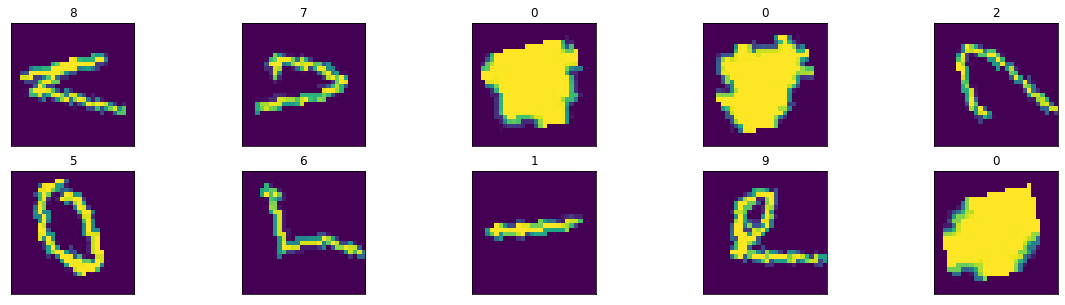

In [10]:
show_img(scripted_transforms(X_train), y_train)

## Create dataset and dataloader

In [11]:
trainset = MNISTDS(X_train, y_train, scripted_transforms)
validset = MNISTDS(X_val, y_val)

In [12]:
batch_size = 100
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(validset, batch_size=batch_size, shuffle=True)

# CNN

In [13]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.batch_1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.batch_2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=2)
        self.batch_3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3)
        self.batch_4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3)
        self.batch_5 = nn.BatchNorm2d(64)
        
        self.conv6 = nn.Conv2d(64, 64, kernel_size=5, stride=2, padding=2)
        self.batch_6 = nn.BatchNorm2d(64)
        
        
        self.fc1 = nn.Linear(1024, 128) 
        self.fc2 = nn.Linear(128, 10)
        
        self.dropout_4 = nn.Dropout(p=0.4)
        
    def forward(self, x):
        x = x.view(x.shape[0], 1, 28, 28)
      
        x = self.conv1(x)
        x = F.relu(x)
        x = self.batch_1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.batch_2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.batch_3(x)
        
        x = self.dropout_4(x)
        
        x = self.conv4(x)
        x = F.relu(x)
        x = self.batch_4(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.batch_5(x)
        
        x = self.conv6(x)
        x = F.relu(x)
        x = self.batch_6(x)

        x = self.dropout_4(x)
      
        x = x.view(-1, 1024)
        
        x = self.fc1(x)
        x = F.relu(x)

        x = self.dropout_4(x)
        x = self.fc2(x)
        
        return x
    
model = Classifier()

## Use GPU if available

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
print(device)

cuda


### Train and validate

In [15]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.35)

In [16]:
epoch = 20
train_losses, valid_losses = [], []
valid_loss_min = np.Inf

for i in range(epoch):
    tot_train_loss = 0
    
    model.train()
    
    for images, labels in train_loader:
 
        pred = model(images.to(device))
        loss = loss_function(pred, labels.to(device))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        tot_train_loss += loss.item()
        
    else:
        tot_valid_loss = 0
        valid_correct = 0
        
        model.eval()
        with torch.no_grad():
        
            for images, labels in valid_loader:      
                pred = model(images.to(device))
                loss = loss_function(pred, labels.to(device))
                tot_valid_loss += loss.item()
        
        train_loss = tot_valid_loss / len(train_loader.dataset)
        valid_loss = tot_valid_loss / len(valid_loader.dataset)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        print("Epoch: {}/{}.. ".format(i+1, epoch),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(valid_loss),
              )
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = valid_loss

Epoch: 1/20..  Training Loss: 0.000..  Test Loss: 0.002.. 
Validation loss decreased (inf --> 0.001702).  Saving model ...
Epoch: 2/20..  Training Loss: 0.000..  Test Loss: 0.001.. 
Validation loss decreased (0.001702 --> 0.000784).  Saving model ...
Epoch: 3/20..  Training Loss: 0.000..  Test Loss: 0.001.. 
Epoch: 4/20..  Training Loss: 0.000..  Test Loss: 0.001.. 
Epoch: 5/20..  Training Loss: 0.000..  Test Loss: 0.001.. 
Validation loss decreased (0.000784 --> 0.000678).  Saving model ...
Epoch: 6/20..  Training Loss: 0.000..  Test Loss: 0.001.. 
Epoch: 7/20..  Training Loss: 0.000..  Test Loss: 0.001.. 
Epoch: 8/20..  Training Loss: 0.000..  Test Loss: 0.001.. 
Validation loss decreased (0.000678 --> 0.000639).  Saving model ...
Epoch: 9/20..  Training Loss: 0.000..  Test Loss: 0.000.. 
Validation loss decreased (0.000639 --> 0.000474).  Saving model ...
Epoch: 10/20..  Training Loss: 0.000..  Test Loss: 0.001.. 
Epoch: 11/20..  Training Loss: 0.000..  Test Loss: 0.001.. 
Epoch: 12

### Train valid loss

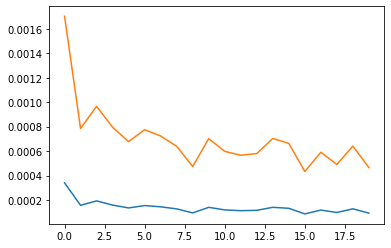

In [17]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

## Load best model

In [18]:
model = Classifier()
model.load_state_dict(torch.load('model.pt'))

model.to(device)

Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (batch_3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch_4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch_5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (batch_6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024,

## Predict test data

In [19]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, images):
        self.images = images.unsqueeze(1).to(device) / 255

    def __len__(self):
        return len(self.images)

    def __getitem__(self, i):
        return self.images[i]
    
    
testset = TestDataset(X_test)
test_loader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=0)

In [20]:
preds_class = np.array([], dtype=int)

with torch.no_grad():
    for images in test_loader:
        preds = model(images.to(device)).cpu()
        preds_class = np.append(preds_class, preds.argmax(dim=1))

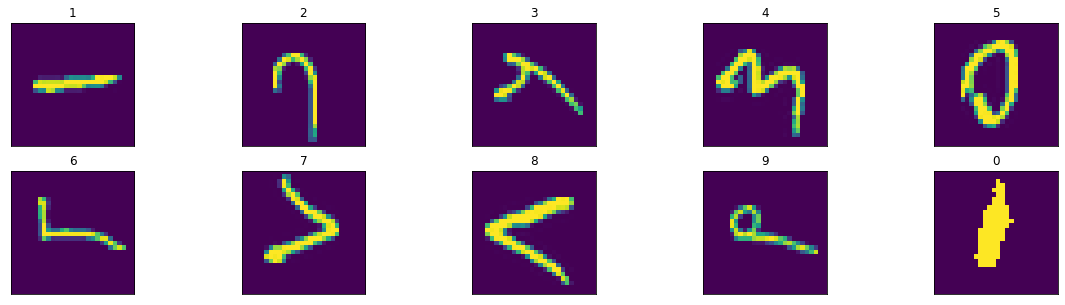

In [21]:
show_img(X_test, preds_class)

# Check accuracy

In [22]:
from sklearn.metrics import accuracy_score

print(f'Accuracy score {accuracy_score(test_label, preds_class)*100:.2f}')

Accuracy score 96.17
